In [1]:
%matplotlib inline

import json
import re
import urllib
from pprint import pprint
import time
from tqdm import tqdm

from py2neo import Node, Graph, Relationship, NodeMatcher
from py2neo.bulk import merge_nodes

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
graph = Graph("bolt://neo4j:7687", name="neo4j", password="kgDemo")
nodes_matcher = NodeMatcher(graph)

# Let's try some more entity disambiguation

Recall in the previous notebook that we looked at the cosine similarity of word vectors.  Instead, now let's look at the overlap of the relationships between our starting node, 'oh bah mə', and  'barack hussein obama ii'.  We might expect if there was strong similarity that we would see a lot of relationship overlap.  

In [12]:
pbo_ls = []
pbo = graph.run('MATCH (n:Node {name: "president barack obama"})--(m) RETURN DISTINCT m.name')
for record in pbo:
    pbo_ls.append(record[0])
print('Total number of connected nodes: ', len(pbo_ls))
pbo_ls

Total number of connected nodes:  1


['affordable care act']

In [13]:
obm_ls = []
obm = graph.run('MATCH (n:Node {name: "oh bah mə"})--(m) RETURN DISTINCT m.name')
for record in obm:
    obm_ls.append(record[0])
print('Total number of connected nodes: ', len(obm_ls))

Total number of connected nodes:  115


In [14]:
pbo_set = set(pbo_ls)
obm_set = set(obm_ls)
if (bho_set & obm_set):
    print('Number of overlapping elements: ', len(pbo_set & obm_set))
    print('Percent of overlapping elements: ', len(pbo_set & obm_set)/len(pbo_ls))
    print(bho_set & obm_set)

Number of overlapping elements:  1
Percent of overlapping elements:  1.0
{'affordable care act'}


# Observation

So we can see that 100% of the nodes connected to 'barack hussein obama ii' are in the connected node list of 'oh bah mə'.  This is a strong indicator that the former might be the same entity as the later.

# Now let's connect to the graph and do some ML

Here we are going to take advantage of the ability to both run Cypher queries in `py2neo` as well as to write the results to a Pandas DataFrame.

In [4]:
df = graph.run('MATCH (n:Node) RETURN n.name, n.node_labels, n.pptu_person, n.pptu_place, n.pptu_thing, n.pptu_unknown, n.word_vec, n.n2v_all_nodes, n.n2v_pptu, n.n2v_all_undir, n.n2v_pptu_undir').to_data_frame()
df.columns = ['name', 'node_labels', 'pptu_person', 'pptu_place', 'pptu_thing', 'pptu_unknown', 'word_vec', 'n2v_all_nodes', 'n2v_pptu', 'n2v_all_undir', 'n2v_pptu_undir']
df['pptu_len'] = df['n2v_pptu'].str.len()
df2 = df.fillna(0)
df2.head()

,name,node_labels,pptu_person,pptu_place,pptu_thing,pptu_unknown,word_vec,n2v_all_nodes,n2v_pptu,n2v_all_undir,n2v_pptu_undir,pptu_len
0,wires,[Thing],0.0,0.0,1.0,0.0,"[0.8980044078720564, 0.006128079628186178, -0....","[0.6094658374786377, 0.6189239621162415, 0.284...","[-0.08293610066175461, -0.26745232939720154, 0...","[0.0823800340294838, -0.352964848279953, 0.319...","[-0.04593001678586006, 0.8721498847007751, -0....",300
1,united states congress,"[Thing, Organization]",1.0,0.0,1.0,0.0,"[0.03312668204307556, 0.07782869786024094, 0.0...","[-0.9871416091918945, 0.373616099357605, 0.456...","[-0.11460854113101959, 0.5099354982376099, 0.3...","[0.5833602547645569, -0.6063153147697449, 0.43...","[0.6923357248306274, 0.06137365847826004, -0.3...",300
2,house,[Thing],0.0,0.0,1.0,0.0,"[0.04616522789001465, 0.3092450797557831, -0.0...","[-0.15712955594062805, -0.05888456106185913, -...","[-0.3770463764667511, -0.6772984862327576, -0....","[0.25968271493911743, 0.23130978643894196, 0.1...","[0.31659290194511414, 0.9325052499771118, -0.2...",300
3,representatives,[Thing],0.0,0.0,1.0,0.0,"[-0.014807065017521381, 0.2798156142234802, -0...","[-0.2792333960533142, -0.08163166791200638, 0....","[-0.9818018674850464, 0.13817954063415527, 0.6...","[0.08528435975313187, 0.5493034720420837, -0.0...","[0.24740058183670044, 0.6874911189079285, 0.60...",300
4,lower chamber,[],0.0,0.0,0.0,1.0,"[0.7092631070122124, 0.8281129557948719, -0.92...","[-0.48839181661605835, 0.32663366198539734, 0....","[-0.5014616847038269, -0.8213402628898621, 0.9...","[-0.18521380424499512, -0.6744221448898315, -0...","[0.42970168590545654, -0.9592905640602112, -0....",300


# Dealing with some missing vectors

Despite our best efforts, we still have some places where `node2vec` did not create embeddings.  There are only a couple of these cases, but it will prevent us from running our models below.  Since we know that `node2vec` was asked to output a 300-dimension embedding, we would expect the value of `pptu_len` to be 300, and will filter out rows where that is not the case.

In [5]:
clean_df = df2[df2['pptu_len'] == 300.]
clean_df.shape

(616, 12)

# Create a variety of `X` variables for the model (in the style of `scikit-learn`)...

In [6]:
def create_X(clean_df):

    word_vec_ls = clean_df['word_vec'].to_list()
    word_vec_arr = np.array([np.array(x) for x in word_vec_ls], dtype=object)

    n2v_an_ls = clean_df['n2v_all_nodes'].to_list()
    n2v_arr = np.array([np.array(x) for x in n2v_an_ls], dtype=object)

    n2v_u_ls = clean_df['n2v_all_undir'].to_list()
    n2v_u_arr = np.array([np.array(x) for x in n2v_u_ls], dtype=object)

    n2v_p_ls = clean_df['n2v_pptu'].to_list()
    n2v_p_arr = np.array([np.array(x) for x in n2v_p_ls], dtype=object)

    n2v_p_u_ls = clean_df['n2v_pptu_undir'].to_list()
    n2v_p_u_arr = np.array([np.array(x) for x in n2v_p_u_ls], dtype=object)

    print(word_vec_arr.shape, n2v_arr.shape, n2v_u_arr.shape, n2v_p_arr.shape, n2v_p_u_arr.shape)
    
    return word_vec_arr, n2v_arr, n2v_u_arr, n2v_p_arr, n2v_p_u_arr

In [7]:
X_word_vec, X_all_nodes, X_all_nodes_u, X_pptu, X_pptu_u = create_X(clean_df)

(616, 300) (616, 300) (616, 300) (616, 300) (616, 300)


# Out of convenience...

...we are creating this function that will run a support vector machine classifier to see how well the different embeddings do at predicting different labels.  We do note that this is a multi-label problem (Person, Place, Thing, Unknown), but for simplicity we are going to evaluate the prediction against single labels within that dataset.  The interested reader is encouraged to try more sophisticated models that can handle the multi-label problem better.

We also show below that each of the classes is significantly imbalanced.  The interested participant is encourage to experiment with balancing the classes to see how this impacts the overall accuracy.

In [19]:
def modeler(df, column_name, X, k_folds=5, model='linear', show_matrix=True):
    
    y = df[column_name].fillna(0.0).to_numpy()
    acc_scores = []
    
    pos = np.count_nonzero(y == 1.0)
    neg = y.shape[0] - pos
    print('Number of positive: ', pos, ' Number of negative: ', neg)
    
    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X_word_vec, y, test_size=0.25)
        clf = svm.SVC(kernel='linear')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return

Number of positive:  116  Number of negative:  500
Accuracy scores:  [0.8246753246753247, 0.8636363636363636, 0.8441558441558441, 0.8571428571428571, 0.8441558441558441]
Mean accuracy:  0.8467532467532468


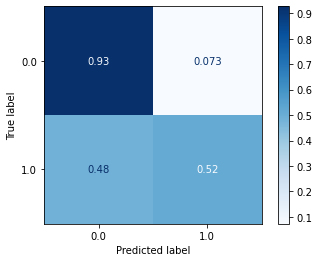

In [20]:
modeler(df, 'pptu_person', X_word_vec)

Number of positive:  116  Number of negative:  500
Accuracy scores:  [0.7987012987012987, 0.7987012987012987, 0.8441558441558441, 0.8441558441558441, 0.8311688311688312]
Mean accuracy:  0.8233766233766234


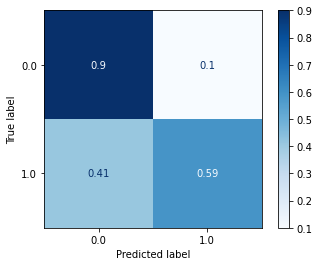

In [21]:
modeler(df, 'pptu_person', X_pptu)

Number of positive:  78  Number of negative:  538
Accuracy scores:  [0.9090909090909091, 0.8896103896103896, 0.948051948051948, 0.9025974025974026, 0.8961038961038961]
Mean accuracy:  0.909090909090909


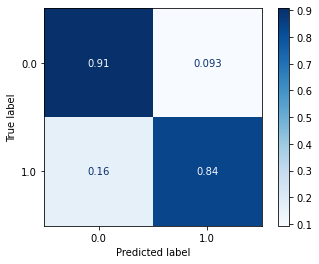

In [22]:
modeler(df, 'pptu_place', X_word_vec)

Number of positive:  78  Number of negative:  538
Accuracy scores:  [0.9155844155844156, 0.9285714285714286, 0.8831168831168831, 0.8961038961038961, 0.9025974025974026]
Mean accuracy:  0.9051948051948052


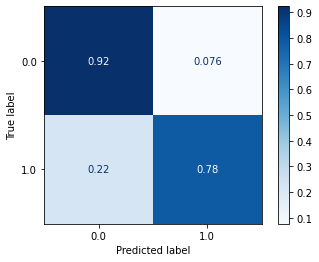

In [23]:
modeler(df, 'pptu_place', X_all_nodes)

Number of positive:  518  Number of negative:  98
Accuracy scores:  [0.9025974025974026, 0.9025974025974026, 0.8701298701298701, 0.8896103896103896, 0.8181818181818182]
Mean accuracy:  0.8766233766233766


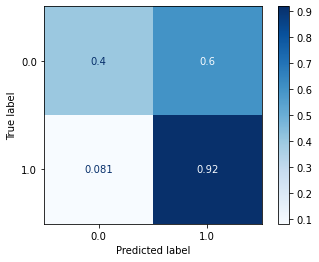

In [24]:
modeler(df, 'pptu_thing', X_word_vec)

Number of positive:  518  Number of negative:  98
Accuracy scores:  [0.8571428571428571, 0.9025974025974026, 0.8571428571428571, 0.9155844155844156, 0.8831168831168831]
Mean accuracy:  0.8831168831168832


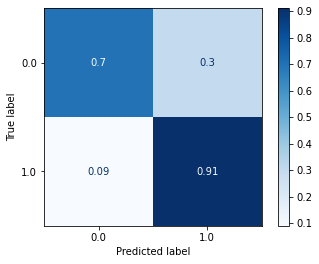

In [25]:
modeler(df, 'pptu_thing', X_pptu_u)

# Next steps

There are so many things that you can try from here!  Some of the things I might consider would be:

- Take time to tune the hyperparameters.  This can be done for:
  - The spacy word embeddings
  - The graph embeddings
  - The ML model
- Trying more sophisticated embedding approaches, such as GraphSAGE, that take into account both the node labels _and_ the edge labels.
- Explore different embeddings.  Here we used the spacy word vectors to create embeddings for the nodes, but there are many, many more ways to create vectors that could be used for training the ML models!  Get creative!
- Work the class imbalance problem.
- This graph is quite small in reality.  Work on growing the graph by adding more layers to it via either Wikipedia or the Google Knowledge Graph.  As the graph gets larger, we might expect that the graph embeddings approaches will start to really shine beyond the word embeddings.

